# 11. 어제 오른 내 주식, 과연 내일은?

ARIMA 모델을 통한 시계열 데이터 예측을 시도합니다.  
1년 동안의 주가 기록을 통해 이후의 주가를 예측하는 실험을 진행합니다.

## 데이터 준비
[Yahoo Finance](https://finance.yahoo.com/)에서 최근 1년 동안의 주가 기록을 다운로드합니다.  
여기서는 [삼성전자의 주가 기록](https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS)을 사용하겠습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action="ignore")

dataset_filepath = "005930.KS.csv"
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


데이터는 날짜에 따른 `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`으로 구성되어 있습니다.  
주식 시장이 마감한 순간의 가격을 나타내는 `Close` 데이터만을 사용합니다.

In [2]:
ts = df["Close"]

ts.head()


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

존재하지 않는 데이터는 `interpolate` 함수를 사용하여 보간합니다. 이후 결측치 존재 여부를 확인합니다.

In [3]:
ts = ts.interpolate(method="time")
ts[ts.isna()]


Series([], Name: Close, dtype: float64)

가격이 약 50,000 에서 90,000 사이로 값이 큰 영역에서 분포하므로 로그 변환을 수행합니다.

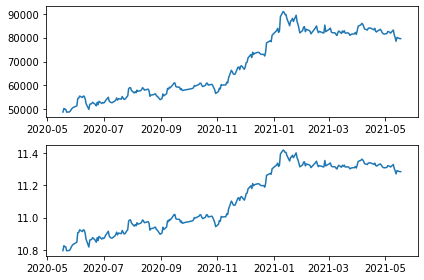

In [4]:
ts_log = np.log(ts)
plt.subplot(2, 1, 1)
plt.plot(ts)
plt.subplot(2, 1, 2)
plt.plot(ts_log)
plt.tight_layout()


## 시계열 안정성 분석

정성적(qualitative) 분석을 위한 함수를 작성합니다.  
- 특성이나 성분을 그래프를 통해서 확인합니다.
- Moving Average와 Moving Standard Deviation을 확인합니다.
- 통계를 구하는 범위(`window`)는 12로 제한합니다.

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    _orig = plt.plot(timeseries, color="blue", label="Original")
    _mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    _std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)



정량적(quantitative) 분석을 위해 ADF test 함수를 작성합니다.
- ADF test: Augemented Dickey-Fuller Test는 단위근(unit root) 통계 검정 방법으로 데이터의 stationary를 확인하는 방법입니다.
- [adfuller 함수](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)를 사용합니다.

In [6]:
from statsmodels.tsa.stattools import adfuller


def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries)

    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value {key}"] = value
    print(dfoutput)


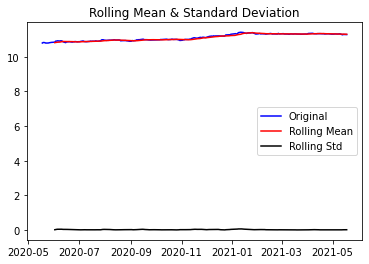

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value 1%               -3.456888
Critical Value 5%               -2.873219
Critical Value 10%              -2.572994
dtype: float64


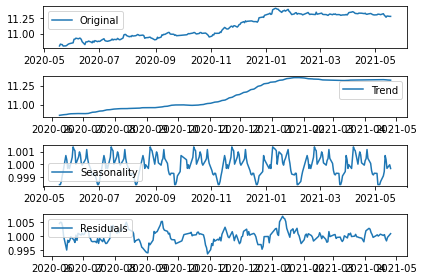

In [7]:
plot_rolling_statistics(ts_log, window=12)
augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model="multiplicative", period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()


Trend와 seasonality가 존재하며, p-value가 0.59로 매우 높습니다.  
Seasonality는 1개월보다 짧은 기간을 기준으로 존재합니다. 이후 ACF와 PAFC를 통해 ARIMA의 모수를 판단하는 과정에서 이를 참고할 수 있습니다.

Trend와 seasonal 요소를 제거한 residual 데이터의 stationary를 확인합니다.

In [8]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value 1%             -3.461879e+00
Critical Value 5%             -2.875404e+00
Critical Value 10%            -2.574159e+00
dtype: float64


p-value가 매우 낮아져 stationary 상태에 가까워졌습니다.

## 학습을 위한 데이터 준비

학습과 테스트를 위해 데이터를 90:10의 비율로 분할합니다.

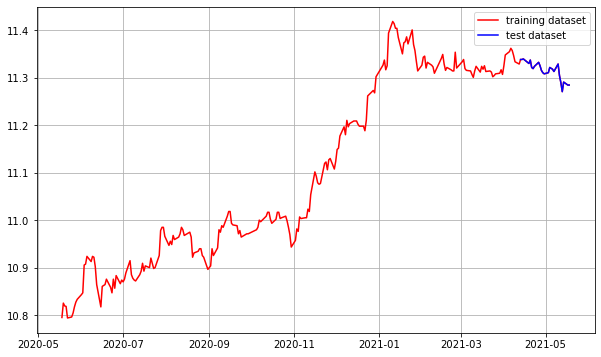

In [9]:
train_data, test_data = (
    ts_log[: int(len(ts_log) * 0.9)],
    ts_log[int(len(ts_log) * 0.9) :],
)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c="r", label="training dataset")
plt.plot(test_data, c="b", label="test dataset")
plt.legend()


## ARIMA 파라미터 탐색

AR 모형을 위한 p, MA 모형을 위한 q와 차분 d를 구하기 위한 과정들을 수행합니다.

Auto Correlation과 Partial Autocorrelation을 구하여 적절한 q와 p를 결정할 수 있습니다.
p, q를 결정하는 여러 기준은 다음의 링크를 참조하였습니다.[(링크)](https://people.duke.edu/~rnau/411arim3.htm)

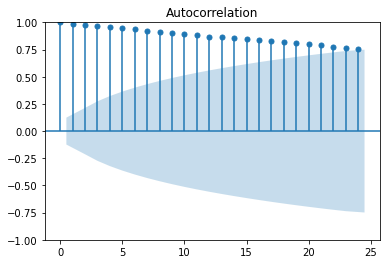

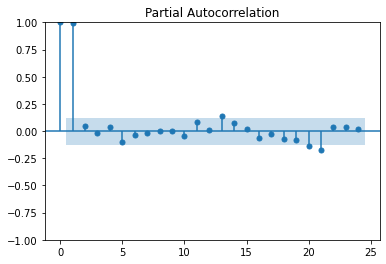

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()


Autocorrelation 그래프를 보면 lag을 크게 키워도 음영 영역을 벗어나는 correlation 값들이 존재하기 때문에, 현재 상태로는 q값을 사용하여 MA 모형을 사용하기는 어렵다고 판단됩니다.  
한편 Partial Autocorrelation 그래프를 보면 lag 1 이후에는 correlation이 거의 존재하지 않아 p값을 1로 설정하여 AR 모형을 사용할 수 있을 것으로 기대됩니다.

다음으로는 차분 d를 구합니다. 우선 1차 차분을 통한 변화를 확인합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value 1%             -3.456996e+00
Critical Value 5%             -2.873266e+00
Critical Value 10%            -2.573019e+00
dtype: float64


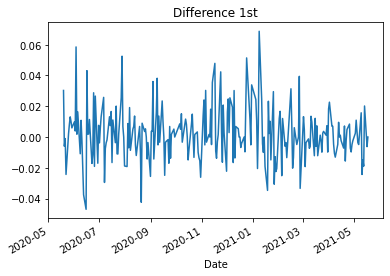

In [11]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)


1차 차분의 결과로도 p-value가 크게 떨어져 1차 이상의 n차 미분은 필요하지 않은 것으로 판단됩니다.

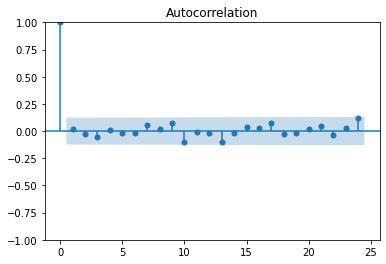

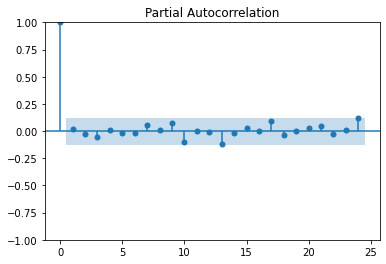

In [12]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()


1차 차분의 결과에 대한 ACF와 PACF를 구하면 어떤 크기의 lag에 대해서도 correlation이 존재하지 않아 AR 또는 MA 모형을 사용하기 어려워 보입니다. 따라서 차분은 적용하지 않겠습니다.

## 모델 훈련 및 테스트

AR, MA, Differential을 모두 사용할 수 있는 [ARIMA 모델](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)을 사용합니다. 모수는 이전에 추정한 값들을 사용합니다.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 0, 0))
fitted_m = model.fit()

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 583.082
Date:                Tue, 15 Feb 2022   AIC                          -1160.164
Time:                        14:41:48   BIC                          -1149.916
Sample:                             0   HQIC                         -1156.028
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.115     96.195      0.000      10.864      11.316
ar.L1          0.9937      0.006    168.571      0.000       0.982       1.005
sigma2         0.0003   2.45e-05     13.135      0.0

C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA 모델을 사용하여 테스트 데이터 기간에 해당하는 주가를 예측합니다. 신뢰 구간(confidence interval)을 나타내는 `forecast()` 함수의 `alpha`는 0.05가 기본으로 설정되어 있습니다.  
예측 결과를 Pandas Series 형태로 변환하여 출력합니다.  

C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


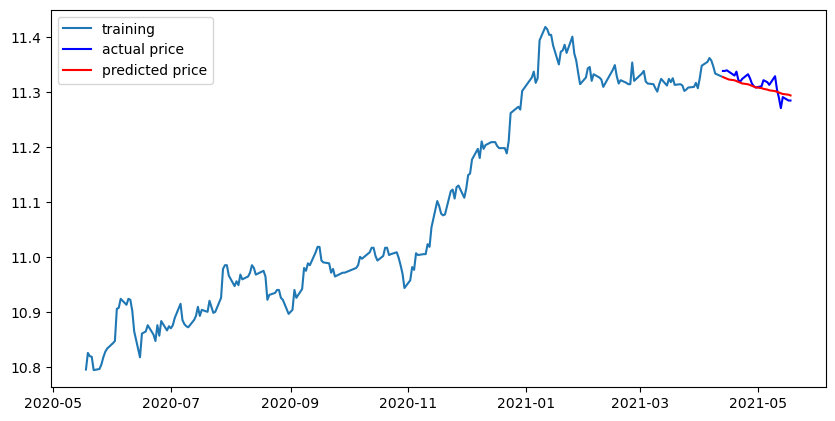

In [14]:
fc = fitted_m.forecast(len(test_data))
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c="b", label="actual price")
plt.plot(fc_series, c="r", label="predicted price")
plt.legend()
plt.show()


그래프에서는 아래로 감소하는 추세가 테스트 데이터와 일치하는 것으로 보입니다.

실제 테스트 데이터와 예측한 결과를 비교하여 성능을 측정합니다.
- MSE(Mean Squared Error): 오차를 제곱한 값들의 평균
- MAE(Mean Absolute Error): 오차의 절댓값들의 평균
- RMSE(Root Mean Squared Error): MSE의 제곱근
- MAPE(Mean Absolute Percentage Error): 오차를 예측값으로 나눈 값의 절대값을 구하고 이 값들의 평균을 구한다
  - 소수의 극단적인 outlier로 인해 MAE가 많은 영향을 받을 수 있어 normalizing 항을 추가한 방법

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def evaluate(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print("MSE: ", mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print("MAE: ", mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print("RMSE: ", rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
    print(f"MAPE: {mape * 100:.2f}%")


evaluate(test_data, fc)



MSE:  1078734.6873191968
MAE:  866.9125685447647
RMSE:  1038.621532281705
MAPE: 1.05%


## 다른 종목(Alphabet Inc.)에 대한 주가 예측

이번에는 [구글(Alphabet Inc.)의 주가 기록](https://finance.yahoo.com/quote/GOOG/history?p=GOOG)을 사용하겠습니다.

In [16]:
dataset_filepath = "GOOG.csv"
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-10,2094.209961,2108.370117,2063.090088,2095.379883,2095.379883,1135500
2021-02-11,2099.510010,2102.030029,2077.320068,2095.889893,2095.889893,945700
2021-02-12,2090.250000,2108.820068,2083.129883,2104.110107,2104.110107,855700
2021-02-16,2104.360107,2152.679932,2104.360107,2121.899902,2121.899902,1133800
2021-02-17,2100.000000,2133.659912,2098.919922,2128.310059,2128.310059,1070900


In [17]:
ts = df["Close"]

ts.head()


Date
2021-02-10    2095.379883
2021-02-11    2095.889893
2021-02-12    2104.110107
2021-02-16    2121.899902
2021-02-17    2128.310059
Name: Close, dtype: float64

결측치를 확인합니다.

In [18]:
ts = ts.interpolate(method="time")
ts[ts.isna()]


Series([], Name: Close, dtype: float64)

데이터가 2,000 에서 3,000 사이에 분포하기 때문에 로그 변환을 적용합니다.

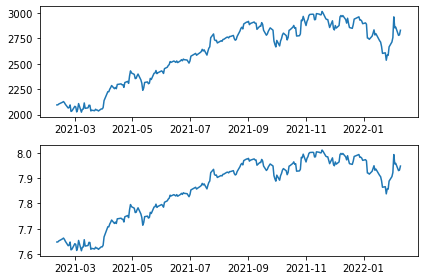

In [19]:
ts_log = np.log(ts)
plt.subplot(2, 1, 1)
plt.plot(ts)
plt.subplot(2, 1, 2)
plt.plot(ts_log)
plt.tight_layout()


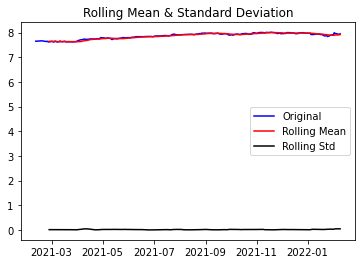

Results of Dickey-Fuller Test:
Test Statistic                  -1.622720
p-value                          0.471303
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value 1%               -3.456569
Critical Value 5%               -2.873079
Critical Value 10%              -2.572919
dtype: float64


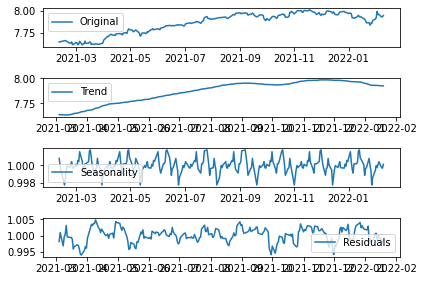

In [20]:
plot_rolling_statistics(ts_log, window=12)
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model="multiplicative", period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()


이번 데이터 역시 seasonality가 존재하며, p-value가 0.47로 높습니다.

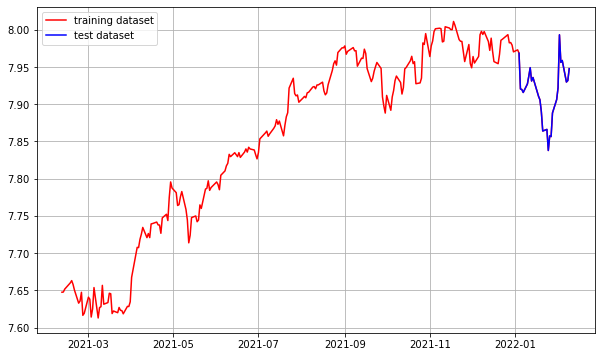

In [21]:
train_data, test_data = (
    ts_log[: int(len(ts_log) * 0.9)],
    ts_log[int(len(ts_log) * 0.9) :],
)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c="r", label="training dataset")
plt.plot(test_data, c="b", label="test dataset")
plt.legend()


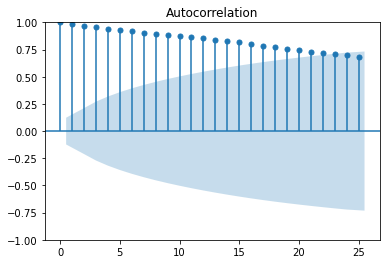

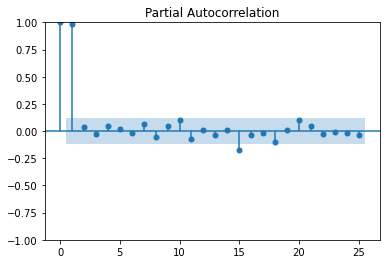

In [22]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()


ACF의 결과, 10 이상의 lag을 선택하여도 이후의 lag들에서 여전히 correlation이 남아있습니다. 현재 상황에서는 MA 모형을 위한 q는 사용하지 않는 것이 좋다고 판단됩니다.  
PACF 결과로는 p를 15로 설정할 수 있을 것 같습니다.

Results of Dickey-Fuller Test:
Test Statistic                -9.805433e+00
p-value                        5.843312e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value 1%             -3.456888e+00
Critical Value 5%             -2.873219e+00
Critical Value 10%            -2.572994e+00
dtype: float64


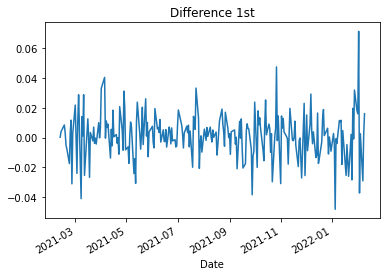

In [23]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)


1차 차분의 결과 p-value가 매우 낮게 확인됩니다. 1차 차분의 결과에 ACF와 PACF를 적용하여 어떤 결과가 나올지 확인합니다.

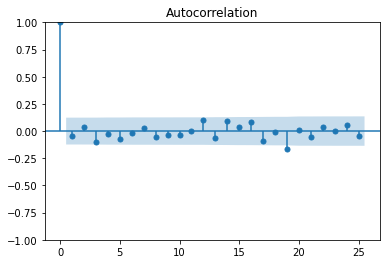

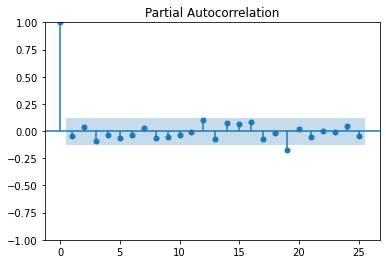

In [24]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()


ACF의 결과 lag이 19인 위치에서 correlation이 존재합니다. 조금 큰 수이기는 하지만 1차 차분 이전 결과와 비교하여 p와 q를 모두 사용할 수 있을 것으로 보여, q를 19로 설정합니다.  
PACF의 결과 역시 lag이 19인 위치에서 correlation이 존재합니다. p를 19로 설정합니다.

In [25]:
model = ARIMA(train_data, order=(19, 1, 19))
fitted_m = model.fit()

print(fitted_m.summary())


C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:               ARIMA(19, 1, 19)   Log Likelihood                 665.554
Date:                Tue, 15 Feb 2022   AIC                          -1253.107
Time:                        14:41:55   BIC                          -1119.707
Sample:                             0   HQIC                         -1199.272
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0011      4.336      0.000      1.000      -8.496       8.499
ar.L2         -0.0408      4.188     -0.010      0.992      -8.249       8.167
ar.L3         -0.0330      3.655     -0.009      0.9

C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


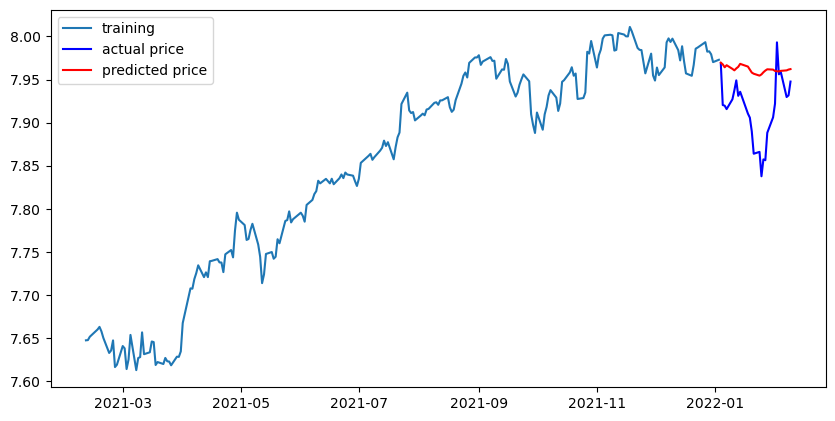

In [26]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c="b", label="actual price")
plt.plot(fc_series, c="r", label="predicted price")
plt.legend()
plt.show()


테스트 데이터 구간의 중간에 급락하는 부분이 존재하여 제대로 예측하지 못하였지만, 해당 급락은 이전의 경향으로는 파악할 수 없는 부분이었기에 모델의 잘못된 학습으로 인한 문제는 아니라 생각됩니다.

In [27]:
evaluate(test_data, fc)


MSE:  25086.712381896094
MAE:  132.83395641321323
RMSE:  158.38785427518138
MAPE: 4.96%


MAPE는 5% 미만으로 적은 오차를 보였습니다.

## 다른 종목(Uber Technologies, Inc.)에 대한 주가 예측

이번에는 [우버(Uber Technologies, Inc.)의 주가 기록](https://finance.yahoo.com/quote/UBER/history?p=UBER)을 사용하겠습니다.

In [28]:
dataset_filepath = "UBER.csv"
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,61.020000,61.310001,59.840000,60.520000,60.520000,15413100
2021-02-17,60.330002,60.950001,58.950001,60.810001,60.810001,12670000
2021-02-18,60.000000,60.290001,58.230000,59.000000,59.000000,15135600
2021-02-19,58.360001,60.457001,58.112999,58.389999,58.389999,28097000
2021-02-22,57.759998,58.099998,54.816002,55.310001,55.310001,25565400


In [29]:
ts = df["Close"]

ts.head()


Date
2021-02-16    60.520000
2021-02-17    60.810001
2021-02-18    59.000000
2021-02-19    58.389999
2021-02-22    55.310001
Name: Close, dtype: float64

In [30]:
ts = ts.interpolate(method="time")
ts[ts.isna()]


Series([], Name: Close, dtype: float64)

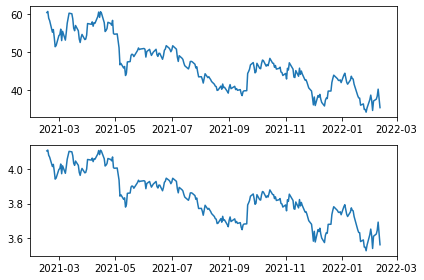

In [31]:
ts_log = np.log(ts)
plt.subplot(2, 1, 1)
plt.plot(ts)
plt.subplot(2, 1, 2)
plt.plot(ts_log)
plt.tight_layout()


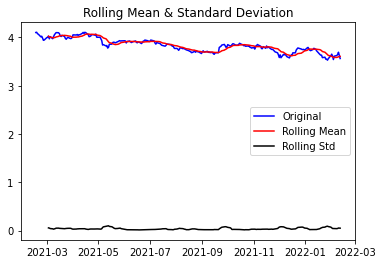

Results of Dickey-Fuller Test:
Test Statistic                  -1.662281
p-value                          0.450644
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value 1%               -3.456674
Critical Value 5%               -2.873125
Critical Value 10%              -2.572944
dtype: float64


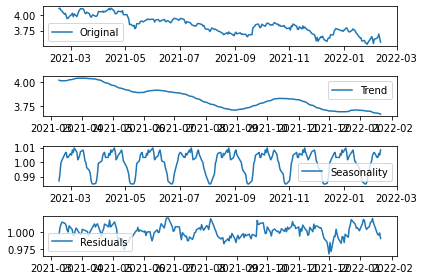

In [32]:
plot_rolling_statistics(ts_log, window=12)
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model="multiplicative", period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()


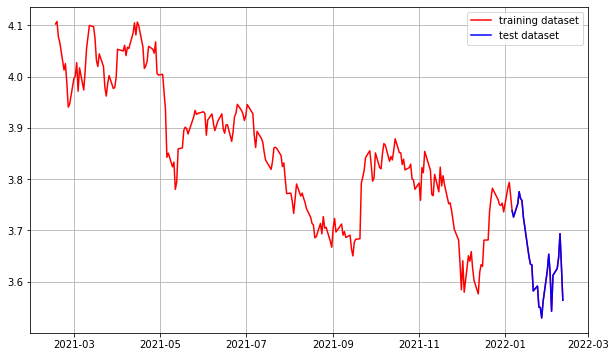

In [33]:
train_data, test_data = (
    ts_log[: int(len(ts_log) * 0.9)],
    ts_log[int(len(ts_log) * 0.9) :],
)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c="r", label="training dataset")
plt.plot(test_data, c="b", label="test dataset")
plt.legend()


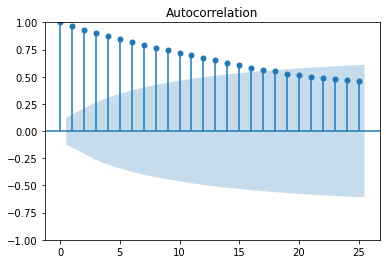

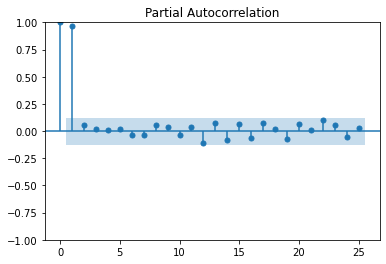

In [34]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()


ACF 결과 correlation이 존재하지 않는 lag은 15 이상으로 매우 큽니다.  
PACF 결과 lag이 1인 이후에는 correlation이 존재하지 않습니다. p는 1로 설정합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.618140e+01
p-value                        4.262697e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value 1%             -3.456781e+00
Critical Value 5%             -2.873172e+00
Critical Value 10%            -2.572969e+00
dtype: float64


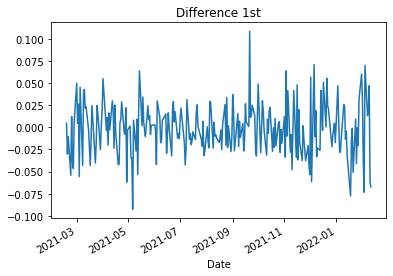

In [35]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)


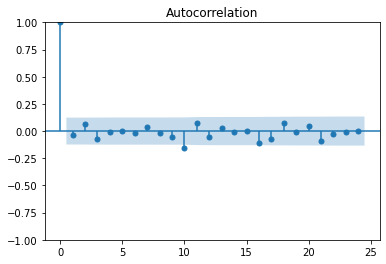

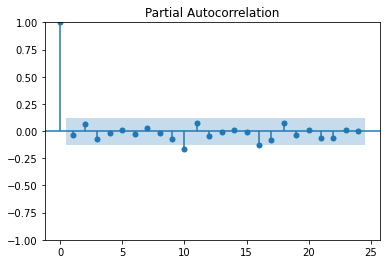

In [36]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()


In [37]:
model = ARIMA(train_data, order=(20, 1, 0))
fitted_m = model.fit()

print(fitted_m.summary())


C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(20, 1, 0)   Log Likelihood                 496.651
Date:                Tue, 15 Feb 2022   AIC                           -951.303
Time:                        14:42:00   BIC                           -879.565
Sample:                             0   HQIC                          -922.349
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0476      0.083     -0.576      0.564      -0.209       0.114
ar.L2          0.1219      0.070      1.737      0.082      -0.016       0.259
ar.L3         -0.0486      0.071     -0.687      0.4

C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


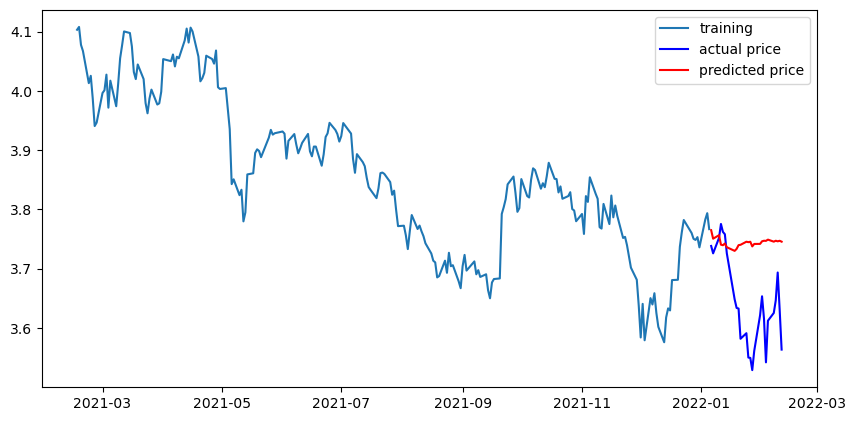

In [38]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c="b", label="actual price")
plt.plot(fc_series, c="r", label="predicted price")
plt.legend()
plt.show()


In [39]:
evaluate(test_data, fc)


MSE:  23.85031742764587
MAE:  4.20380850019994
RMSE:  4.883678677763911
MAPE: 11.51%


## 결론

- ACF와 PACF를 통하여 ARIMA 모델의 모수를 선택하였으나, ADF test를 통해 얻은 seasonal 속성과 trend 속성에 대한 반영은 쉽지 않았습니다.
- 주가는 이전 상태의 영향을 받지만 외부 요소에 의한 영향을 많이 받아 급작스럽게 증가하거나 감소하는 상황은 제대로 예측할 수 없었습니다.

## 루브릭

| 평가문항                                               | 상세기준                                                       |
| ------------------------------------------------------ | -------------------------------------------------------------- |
| 1. 시계열의 안정성이 충분히 확인되었는가?              | 플로팅과 adfuller 메소드가 모두 적절히 사용되었음              |
| 2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨 |
| 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? | 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨                |


### 루브릭 자체평가

1. 데이터를 그래프로 표현하고 adf test를 적절히 사용하였다.
2. 모수 선택을 ACF와 PACF를 기반으로 진행하였다.
3. 3개의 종목에 대해서 15%의 미만의 MAPE를 달성하였다.